In [1]:
# import torch
import torch, tqdm
import torch.nn as nn
import torchvision.models as models

from torchvision.models.vision_transformer import Encoder, EncoderBlock
from myAdaRound.data_utils import save_inp_oup_data, _get_train_samples
from myAdaRound.utils import evaluate, GetDataset


import matplotlib.pyplot as plt

ImportError: attempted relative import with no known parent package

In [ ]:
"""

여기 33번라인 활성화해야 activation weight == Softmax(QK^T/sqrt(d_k)) 가 나옴

class EncoderBlock(nn.Module):
    """Transformer encoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=attention_dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_2 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        x = self.ln_1(input)
        x, _ = self.self_attention(x, x, x, need_weights=False)
        # x, _ = self.self_attention(x, x, x, need_weights=True) # @jiho264, modify for attention map
        x = self.dropout(x)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y


"""

In [ ]:
# prepare the model
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
model.eval().to("cuda")

_batch_size = 32

train_loader, test_loader = GetDataset(batch_size=_batch_size)

num_samples = 3 * _batch_size

cali_data = _get_train_samples(train_loader, num_samples)

saver = dict()


def save_name_input_output_hook(module, input, output, module_name):

    global saver
    
    saver[module_name] = (input, output)
    
    print(module_name, "saved !")


""" ViT """
for name, module in model.named_children():
    """ Encoder """
    if isinstance(module, Encoder):
        for encoderBlocksNum, encoderBlocks in module.named_children():
            """ EncoderBlocks """
            if isinstance(encoderBlocks, nn.Sequential):  # 12 EncoderBlock
                for bname, block in encoderBlocks.named_children():
                    """ each EncoderBlock """
                    if isinstance(block, EncoderBlock):
                        for layerName, layerModule in block.named_children():
                            """ inside of EncoderBlock """
                            if layerName == "dropout":
                                continue

                            layerModule.register_forward_hook(
                                lambda mod, inp, out, layerName=layerName: save_name_input_output_hook(
                                    mod, inp, out, layerName
                                )
                            )
                            print(layerName, "hooked !")

                    break

model(cali_data.to("cuda"))

print("")

ln_1 hooked !
self_attention hooked !
ln_2 hooked !
mlp hooked !
ln_1 saved !
self_attention saved !
ln_2 saved !
mlp saved !



In [ ]:
saver.keys()

dict_keys(['ln_1', 'self_attention', 'ln_2', 'mlp'])

In [ ]:
def plot_data(input, output, title: str):

    inshape = input.shape
    outshape = output.shape

    input = input.cpu().detach().numpy().flatten()
    output = output.cpu().detach().numpy().flatten()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].hist(input, bins=100, alpha=0.5, label="Input")
    ax[1].hist(output, bins=100, alpha=0.5, label="Output")
    ax[0].set_yscale("log")
    ax[1].set_yscale("log")
    # if title == "attn_map":
    #     ax[0].set_xscale("log")
    #     ax[1].set_xscale("log")
    #     ax[0].set_yscale("linear")
    #     ax[1].set_yscale("linear")
    _titlestr = f"{title} \n input.shape: {inshape}, output.shape: {outshape}"
    fig.suptitle(_titlestr)

    plt.show()

    if title in ["self_attention", "mlp"]:
        print("residual addition")

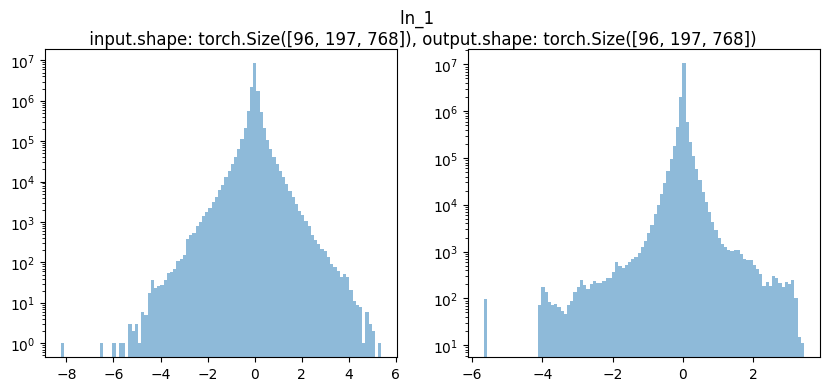

attention_map


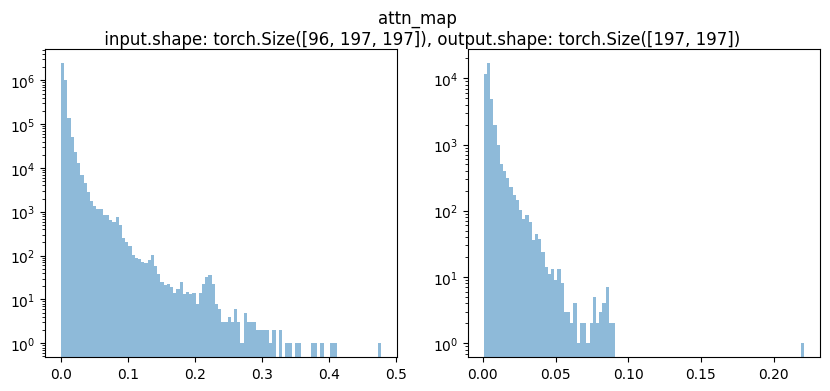

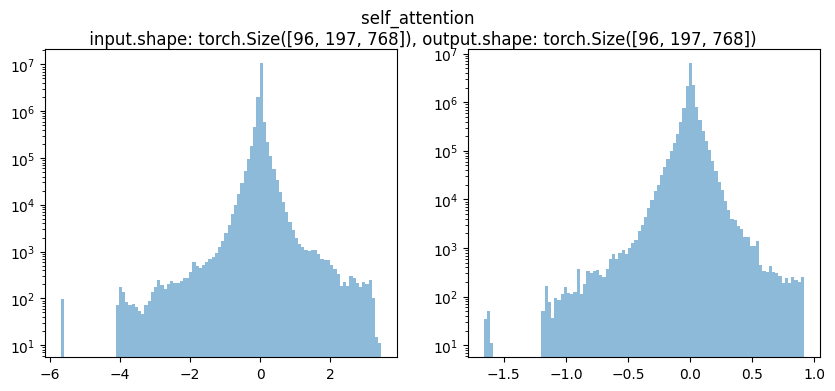

residual addition


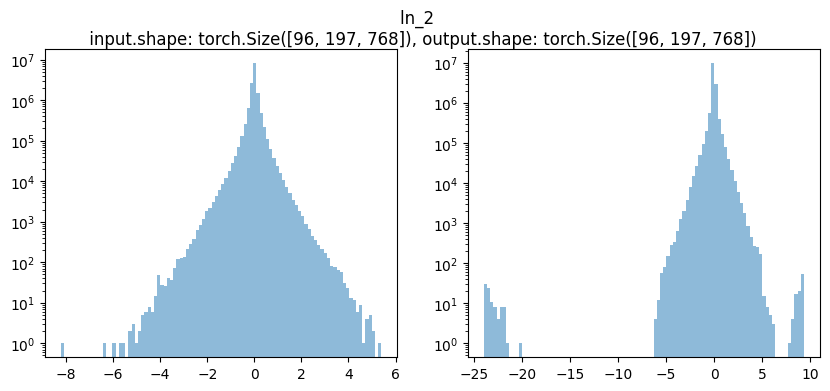

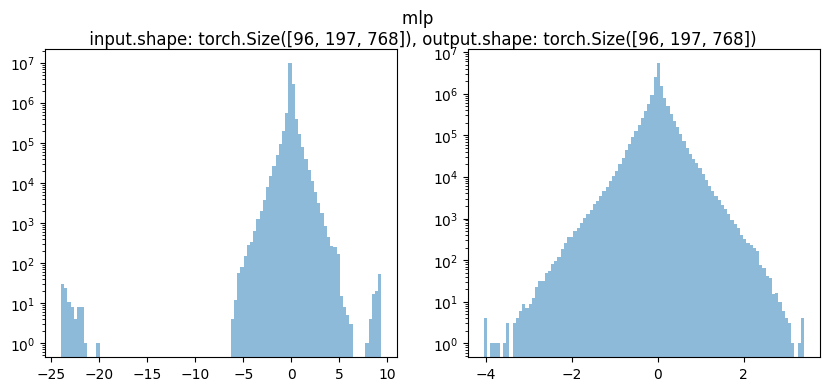

residual addition


In [ ]:
for key, value in saver.items():
    if key == "self_attention":
        _in, _out = value[0][0], value[1][0]
        print("attention_map")
        # (197, 197)
        # print(value[1][1][0].shape, value[1][1][0].sum())
        
        # (197)
        # print(value[1][1][0][0].shape, value[1][1][0][0].sum())
        # scalar
        # print(value[1][1][0][0][0].shape, value[1][1][0][0][0].sum())
        plot_data(value[1][1], value[1][1][0], "attn_map")
    else:
        _in, _out = value[0][0], value[1]

    plot_data(_in, _out, key)